# Load Libraries and Data

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import StratifiedKFold

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [2]:
# Paths to data files
train_csv_path = './data/processed_train_df_drop_one_no_target.csv'
test_csv_path = './data/processed_test_df_drop_one_no_target.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Preprocessing

In [3]:
# Separate features and target
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)

X_test = test_df.drop(columns=['id'])

In [4]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data
#categorical_pipeline = Pipeline(steps=[
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols)#,
#    ('cat', categorical_pipeline, categorical_cols)
])

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fitting SVM Model

In [6]:
# Create a Pipeline that includes preprocessing and the SVM classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SVC())
])

In [7]:
params = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__degree': [3, 4],  # Only relevant for 'poly' kernel
    'svm__class_weight': [None, 'balanced']
}

In [8]:
def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

qwk_scorer = make_scorer(qwk_scorer, greater_is_better=True)

In [9]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [10]:
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,                     # 10-fold cross-validation
    scoring=qwk_scorer,        # Use kappa_scorer as the scoring metric
    refit=True,
    verbose=2,
    n_jobs=-1
)

# Fit the model on the training data
gs.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Basic_Demos-Age',
                                                                          'CGAS-CGAS_Score',
                                                                          'Physical-BMI',
                                                                          'Physical-Height',
                                                                          'Physical-Weight',
                                                                          'Physical-Waist_Circumference',
                                                                          'Physical-Diastolic_BP',
                                                                          'Physi...
                                                                          'BIA-BIA_ECW',
                                                                          'BIA-BIA_FFM',
                                                                          'BIA-BIA_FFMI',
                                                                          'BIA-BIA_FMI',
                                                                          'BIA-BIA_Fat',
                                                                          'BIA-BIA_ICW',
                                                                          'BIA-BIA_LDM', ...])])),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__degree': [3, 4], 'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf', 'linear', 'poly']},
             scoring=make_scorer(qwk_scorer, response_method='predict'),
             verbose=2)

# Evaluating SVM Model

In [11]:
# Print best cross-validation score and parameters
print(f"\nBest QWK Score: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")


Best QWK Score: 0.9633
Best Parameters: {'svm__C': 1, 'svm__class_weight': None, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


In [12]:
# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_

# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9672


In [13]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       319
           1       0.93      0.97      0.95       146
           2       0.96      0.92      0.94        76
           3       0.75      0.86      0.80         7

    accuracy                           0.97       548
   macro avg       0.91      0.93      0.92       548
weighted avg       0.97      0.97      0.97       548



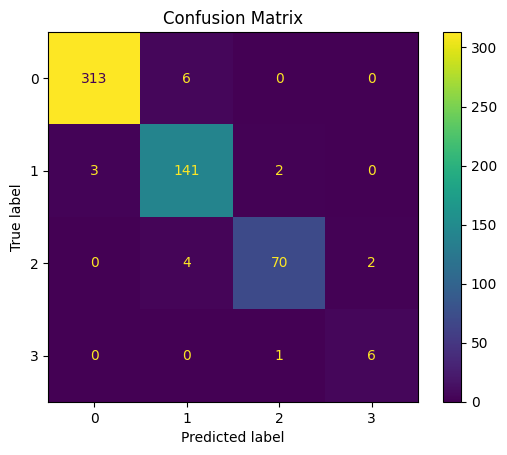

In [14]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Make predictions on the test set
y_test_pred = best_pipeline.predict(X_test)

# Save the predictions to a file
output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred})
#output_df.to_csv('submission.csv', index=False)

In [16]:
output_df

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1


# Saving the SVM Model

In [17]:
# Save the best model pipeline
joblib.dump(best_pipeline, 'best_svm_model.pkl')

print("\nBest SVM model has been saved successfully.")


Best SVM model has been saved successfully.
